In [97]:
import matplotlib.pyplot as plt

In [98]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [100]:
from tensorflow.keras.models import Sequential

In [101]:
from tensorflow.keras import optimizers

In [102]:
from sklearn.metrics import f1_score 

In [103]:
import tensorflow as tf

In [104]:
import numpy as np

In [105]:
import cv2

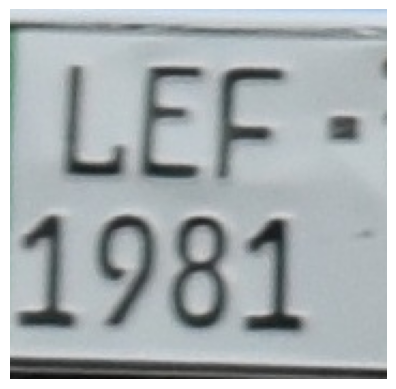

In [106]:
import cv2
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('DSC_0427.jpg')  # Adjust the path to your image file

# Calculate cropping boundaries
height, width, _ = img.shape
left_crop = int(width * 0.23)
right_crop = int(width * 0.18)

# Perform cropping
cropped_img = img[:, left_crop:width - right_crop]

# Save the cropped image
cv2.imwrite('cropped_image.png', cropped_img)

# Display the cropped image using Matplotlib
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


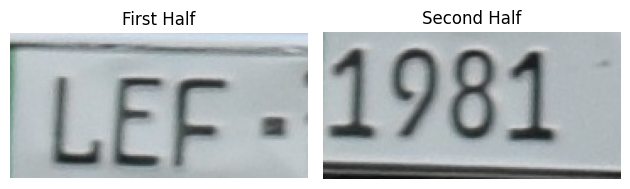

In [107]:
import cv2
import matplotlib.pyplot as plt

# Load the cropped image
cropped_img = cv2.imread('cropped_image.png')

# Calculate image dimensions
height, width, _ = cropped_img.shape

# Calculate the division point (vertically)
division_point = height // 2

# Divide the image into two parts
first_half = cropped_img[:division_point, :]
second_half = cropped_img[division_point:, :]

# Display the first half
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(first_half, cv2.COLOR_BGR2RGB))
plt.title('First Half')
plt.axis('off')

# Display the second half
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(second_half, cv2.COLOR_BGR2RGB))
plt.title('Second Half')
plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_contours(dimensions, img) :
    
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = 50
    upper_width = 100
    lower_height = 10
    upper_height = 100
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_characters(image) :
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3), iterations=1)
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3), iterations=1)

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/3,
                       LP_HEIGHT/3,
                       2*LP_HEIGHT/2]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    
    char_list = find_contours(dimensions, img_binary_lp.copy())

    return char_list


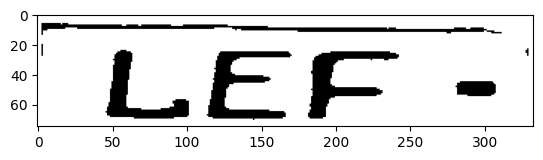

In [110]:
char_FirstHalf = segment_characters(first_half)

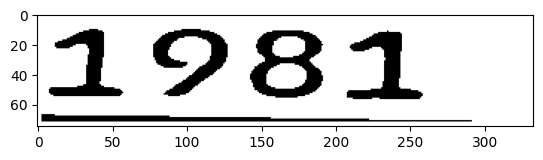

In [111]:
char_SecondHalf = segment_characters(second_half)

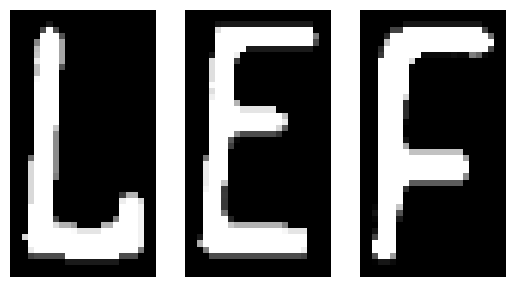

In [112]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(char_FirstHalf[i], cmap='gray')
    plt.axis('off')
plt.show()


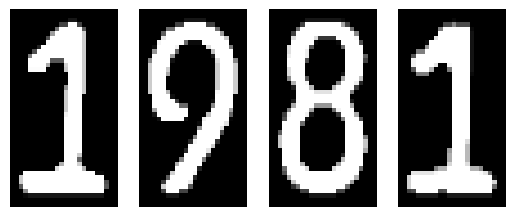

In [113]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(char_SecondHalf[i], cmap='gray')
    plt.axis('off')
plt.show()


### Model for characters

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,  # Perhatikan bahwa nilai ini adalah fraksi dari total lebar gambar
    height_shift_range=0.1  # Perhatikan bahwa nilai ini adalah fraksi dari total tinggi gambar
)

path = 'C:\\Users\\raide\\Documents\\my_environment\\project\\number_plate_recognition_using_cnn\\ai_license_plate_recognition_data\\data\\data'

train_generator = train_datagen.flow_from_directory(
    path+'/train',
    target_size=(28, 28),
    batch_size=1,
    class_mode='sparse'
)

validation_generator = train_datagen.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    class_mode='sparse'
)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [115]:
from sklearn.metrics import f1_score
import tensorflow as tf

def f1score(y_true, y_pred):
    return f1_score(y_true, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y_true, y_pred):
    return tf.py_function(f1score, (y_true, y_pred), tf.double)


In [116]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers
from keras import backend as K  # Import keras.backend as K
from sklearn.metrics import f1_score
import tensorflow as tf

def f1score(y_true, y_pred):
    return f1_score(y_true, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y_true, y_pred):
    return tf.py_function(f1score, (y_true, y_pred), tf.double)

# Clear previous session to avoid clutter from old models/layers
K.clear_session()

# Define the model
model = Sequential([
    Conv2D(16, (22, 22), input_shape=(28, 28, 3), activation='relu', padding='same'),
    Conv2D(32, (16, 16), activation='relu', padding='same'),
    Conv2D(64, (8, 8), activation='relu', padding='same'),
    Conv2D(64, (4, 4), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(36, activation='softmax')
])

# Compile the model with the correct learning rate argument
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])


**Testing different Combinations**

In [117]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])


In [118]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │        23,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,268 (2.89 MB)

 Trainable params: 757,268 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_custom_f1score') > 0.99:
            self.model.stop_training = True


In [120]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("Logs:", logs)
        if logs.get('val_custom_f1score') > 0.99:
            self.model.stop_training = True


In [121]:
model.save("model.h5")

In [122]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(characters, char_FirstHalf, model):
    dic = {}
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_FirstHalf:
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

# Usage example:
# plate_number = show_results(characters, char_FirstHalf, model)
# print(plate_number)


In [123]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(characters, char_SecondHalf, model):
    dic = {}
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_SecondHalf:
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

# Usage example:
# plate_number = show_results(characters, char_SecondHalf, model)
# print(plate_number)


In [124]:
def show_results_FirstHalf():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_FirstHalf:
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension_FirstHalf(img_)
        img = img.reshape(1, 28, 28, 3)
        y_prob = model.predict(img)[0]  # Get predicted probabilities for each class
        y_class = np.argmax(y_prob)  # Get the class with the highest probability
        character = dic[y_class]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number

def show_results_SecondHalf():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_SecondHalf:
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension_SecondHalf(img_)
        img = img.reshape(1, 28, 28, 3)
        y_prob = model.predict(img)[0]  # Get predicted probabilities for each class
        y_class = np.argmax(y_prob)  # Get the class with the highest probability
        character = dic[y_class]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number


In [125]:
def show_results_FirstHalf():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_FirstHalf:
        print(type(ch))  # Tambahkan ini untuk memeriksa tipe variabel ch
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension_FirstHalf(img_)
        img = img.reshape(1, 28, 28, 3)
        y_prob = model.predict(img)[0]  # Get predicted probabilities for each class
        y_class = np.argmax(y_prob)  # Get the class with the highest probability
        character = dic[y_class]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number

def show_results_SecondHalf():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char_SecondHalf:
        print(type(ch))  # Tambahkan ini untuk memeriksa tipe variabel ch
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension_SecondHalf(img_)
        img = img.reshape(1, 28, 28, 3)
        y_prob = model.predict(img)[0]  # Get predicted probabilities for each class
        y_class = np.argmax(y_prob)  # Get the class with the highest probability
        character = dic[y_class]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number


In [126]:
file_path = r"C:\Users\raide\Documents\my_environment\project\number_plate_recognition_using_cnn\data.txt"  # Specify the file path

# Open the file in write mode
with open(file_path, 'w') as file:
    file.write("John Doe,ABC1293\n")
    file.write("Jane Smith,LEB5700\n")
    file.write("Mark Johnson,PQR4756\n")
    file.write("Mohsin Ali,LEC4800\n")
    file.write("Ahmad Jalal,XYZ7890\n")
    file.write("Jalal Ali,PQR4563\n")
    file.write("Ali Hassan,LEA4861\n")
    file.write("Jameel,LER1234\n")
